Loading simulation data from /home/openfoamuser/Geo-UPSplus/dataset_gen/Flowbench_Openfoam/FPO_cylinder/Hole_Location/results_batch_1.npy
Data shape: (1, 20, 16128, 4)
Loading JSON file: /home/openfoamuser/Geo-UPSplus/dataset_gen/Flowbench_Openfoam/FPO_cylinder/Hole_Location/sim_data_batch_1.json
Loaded JSON with 1 entries total.


Reshaping Trajectories: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
/tmp/ipykernel_113899/2152998656.py:137: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('gist_ncar').copy()


Saved combined trajectory data at: FNO_data/combined.npy
Combined reshaped data shape: (1, 20, 128, 128, 7)
Plotting sample trajectory (index 58)...


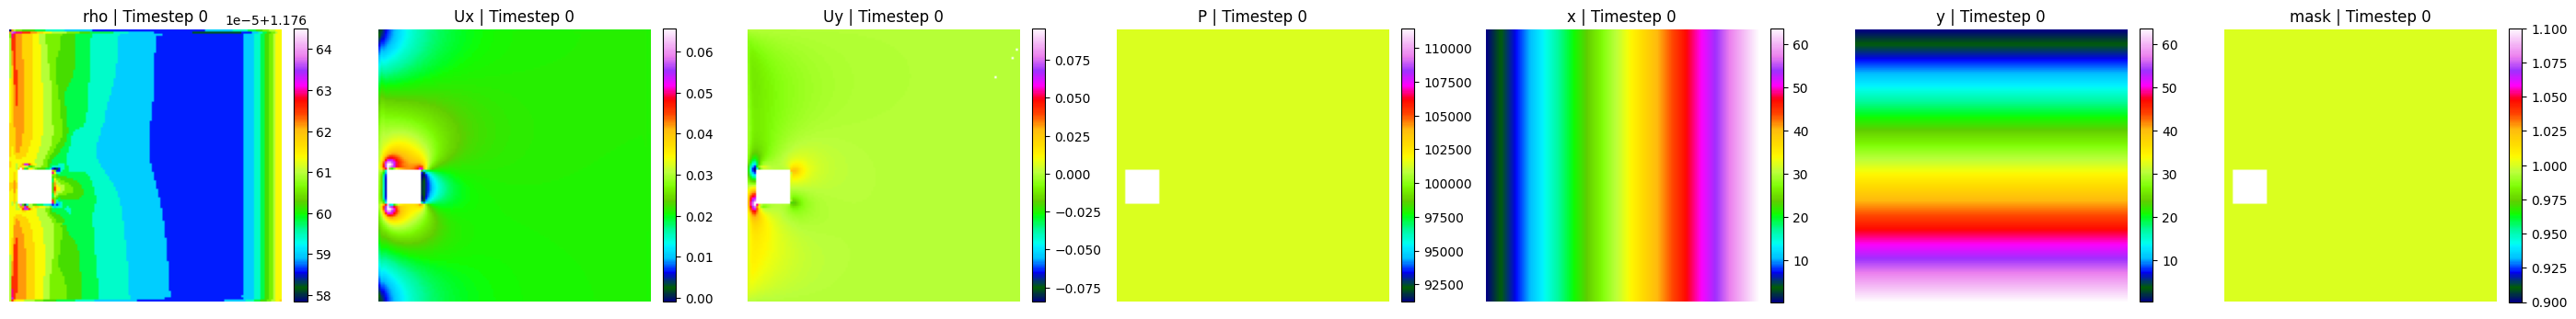

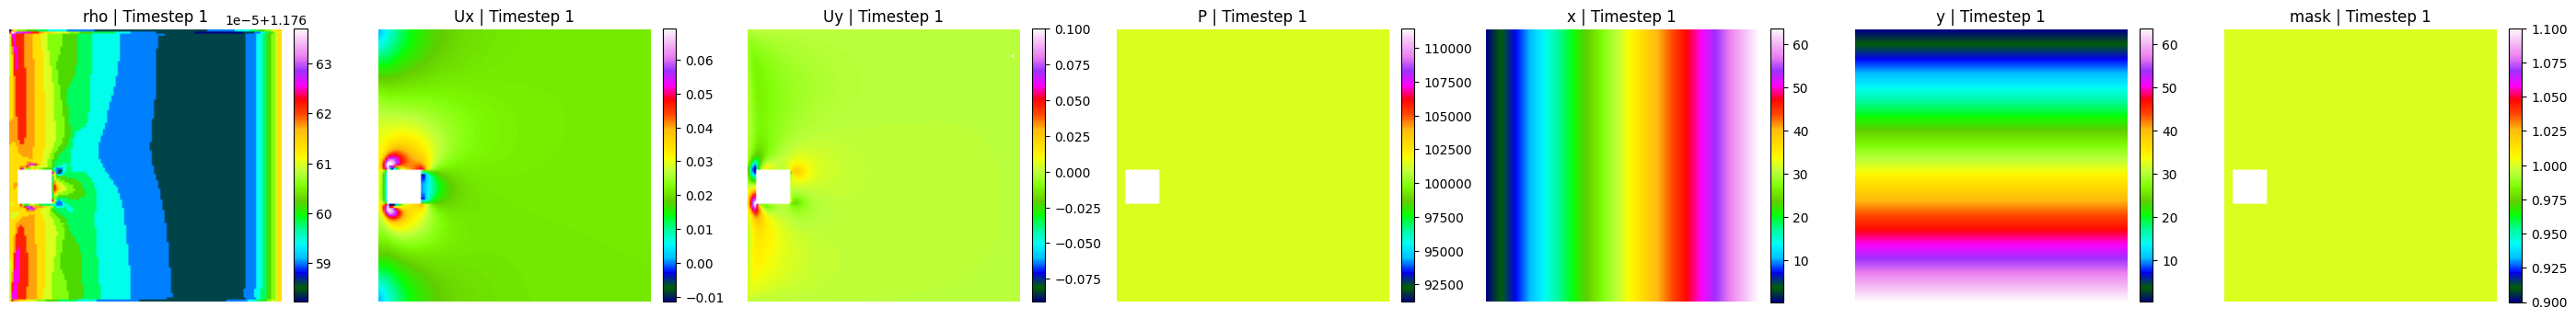

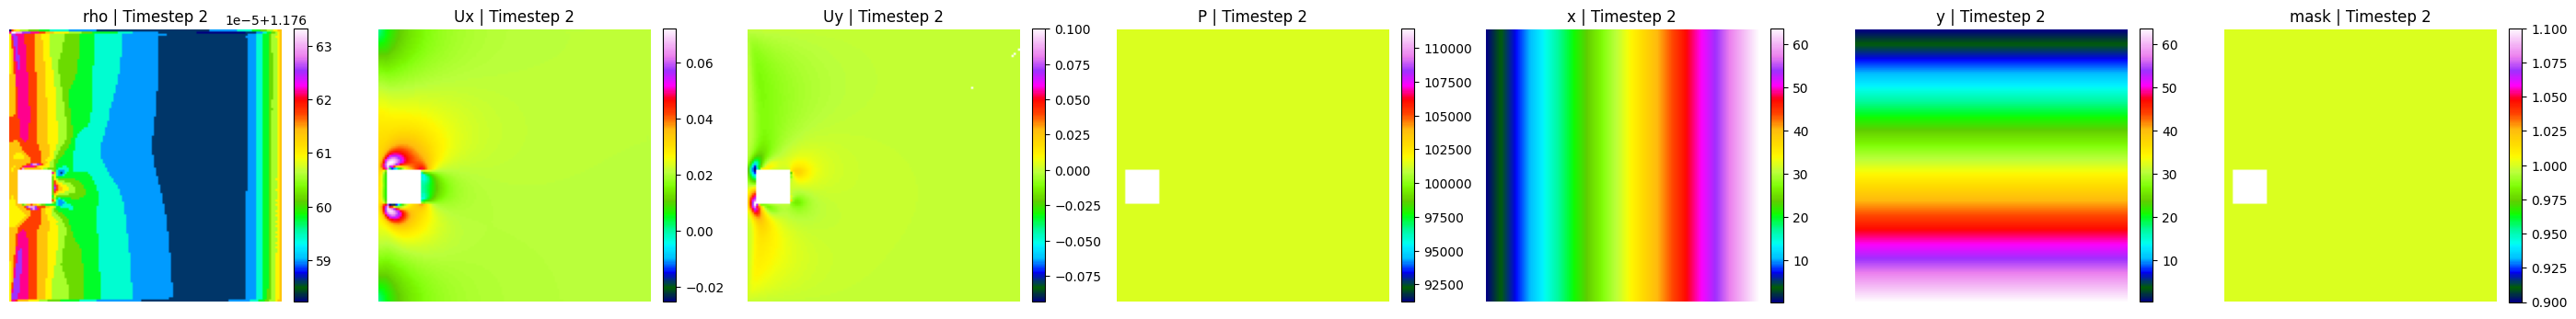

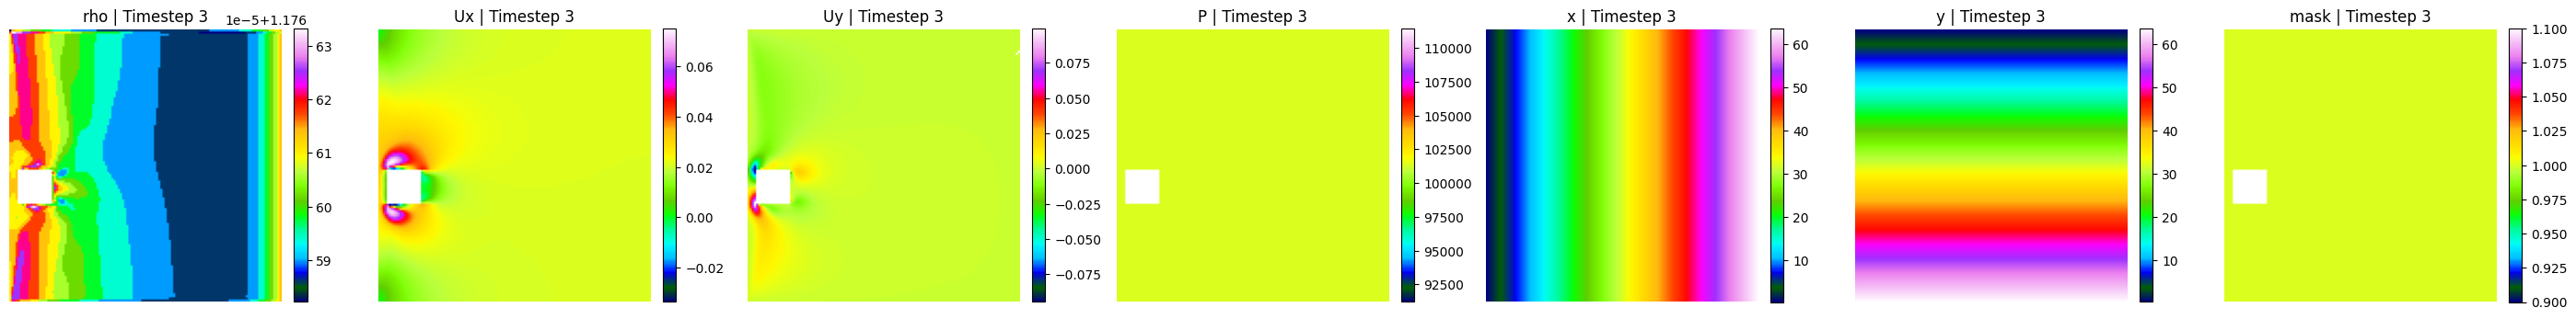

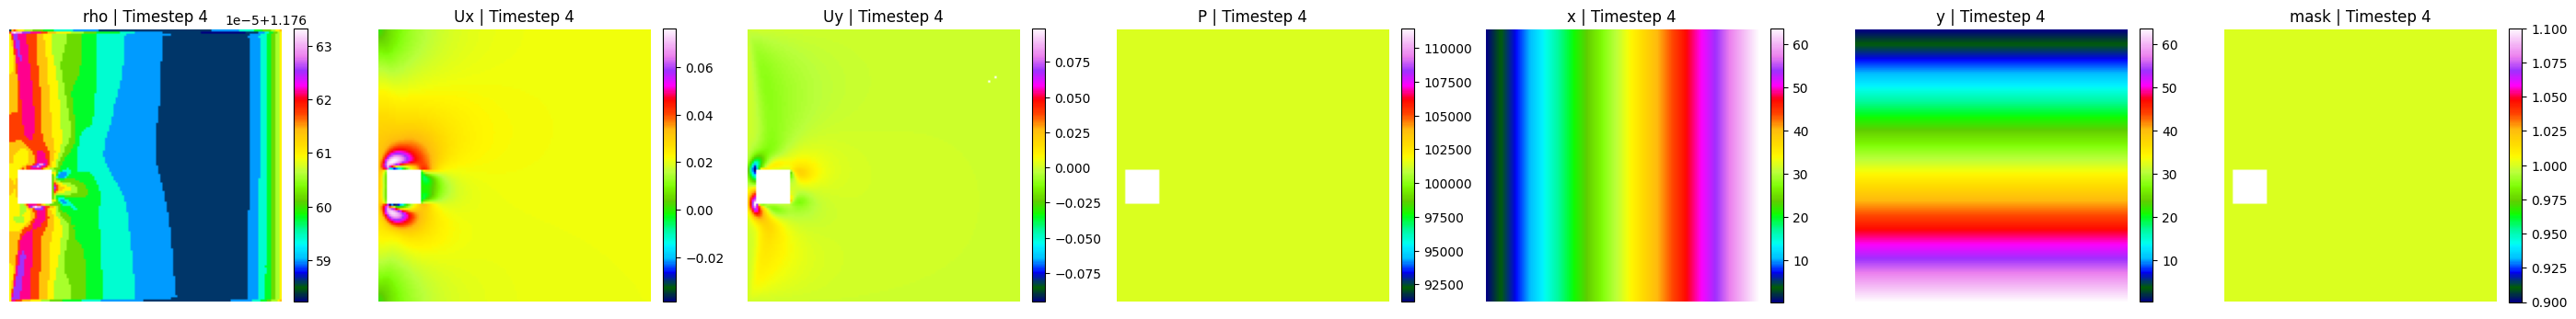

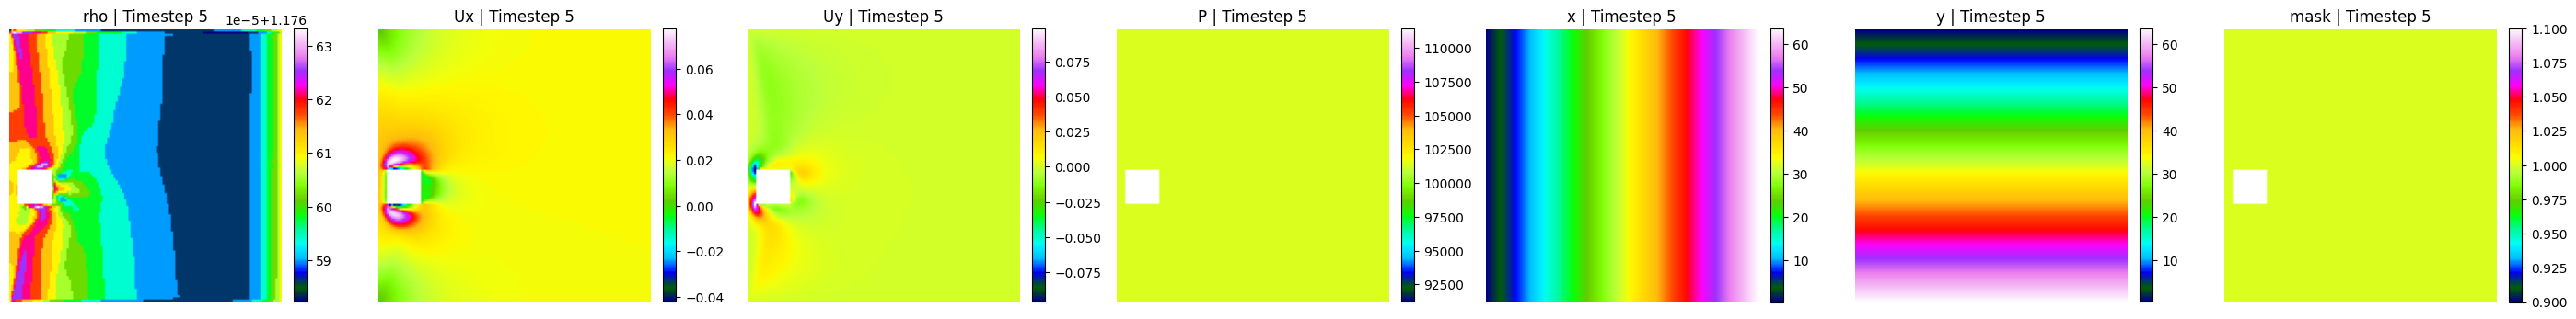

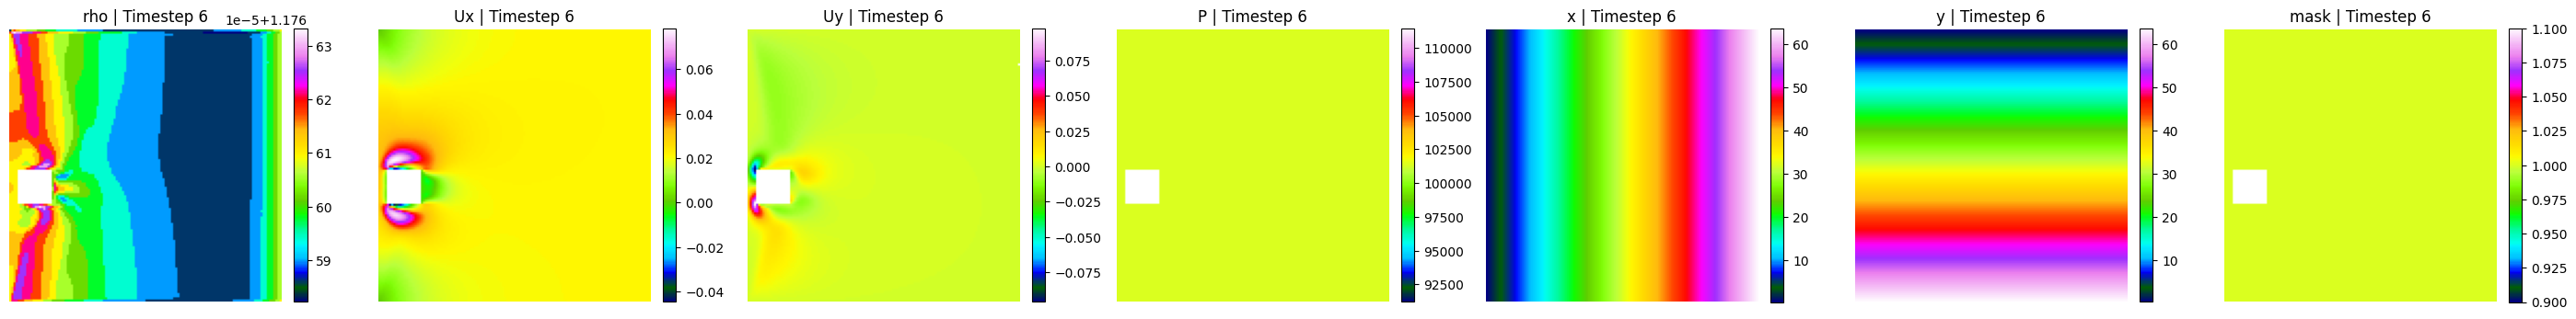

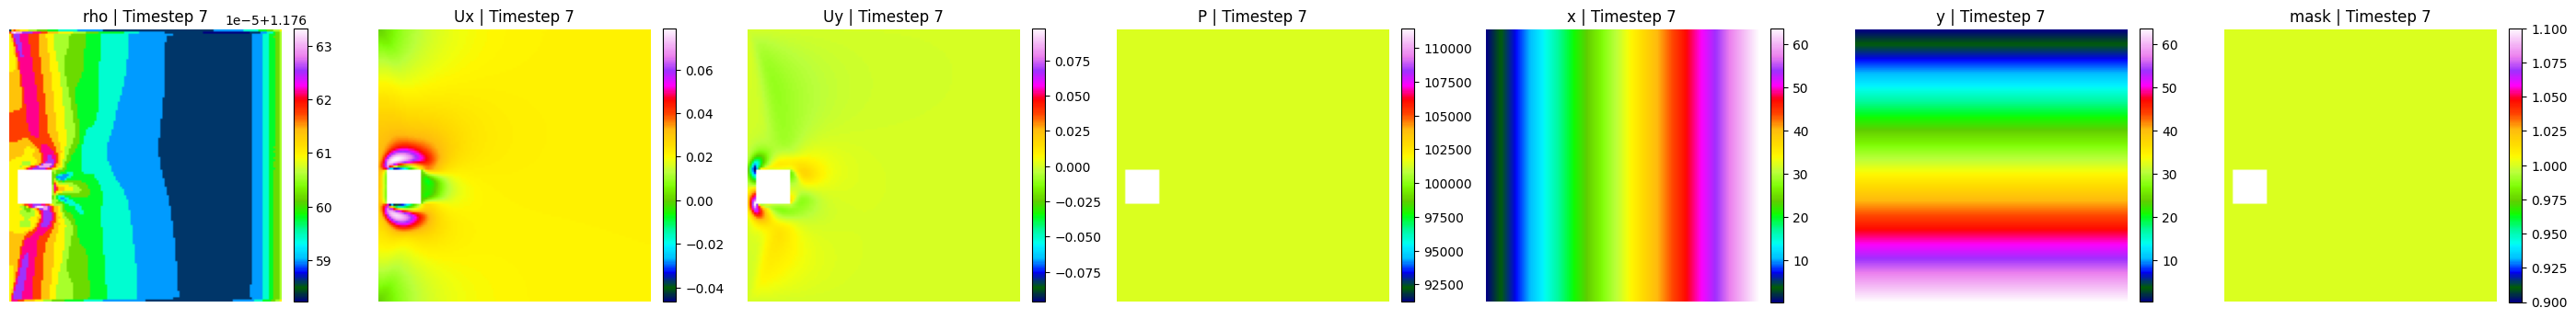

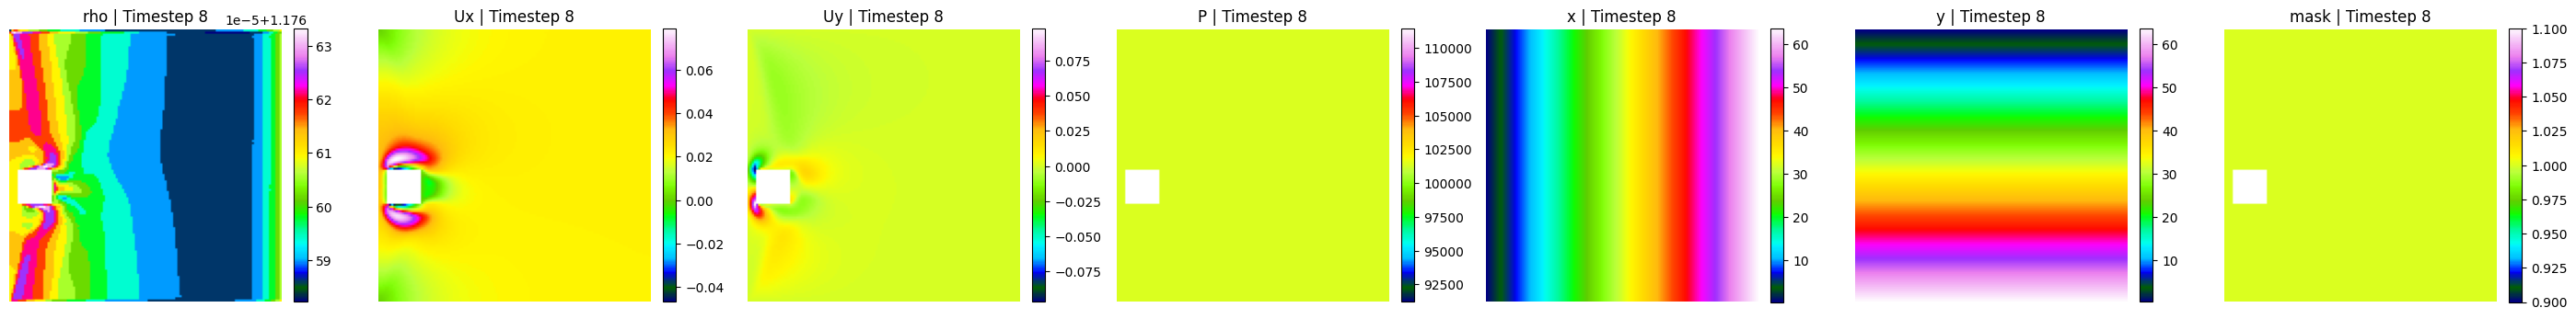

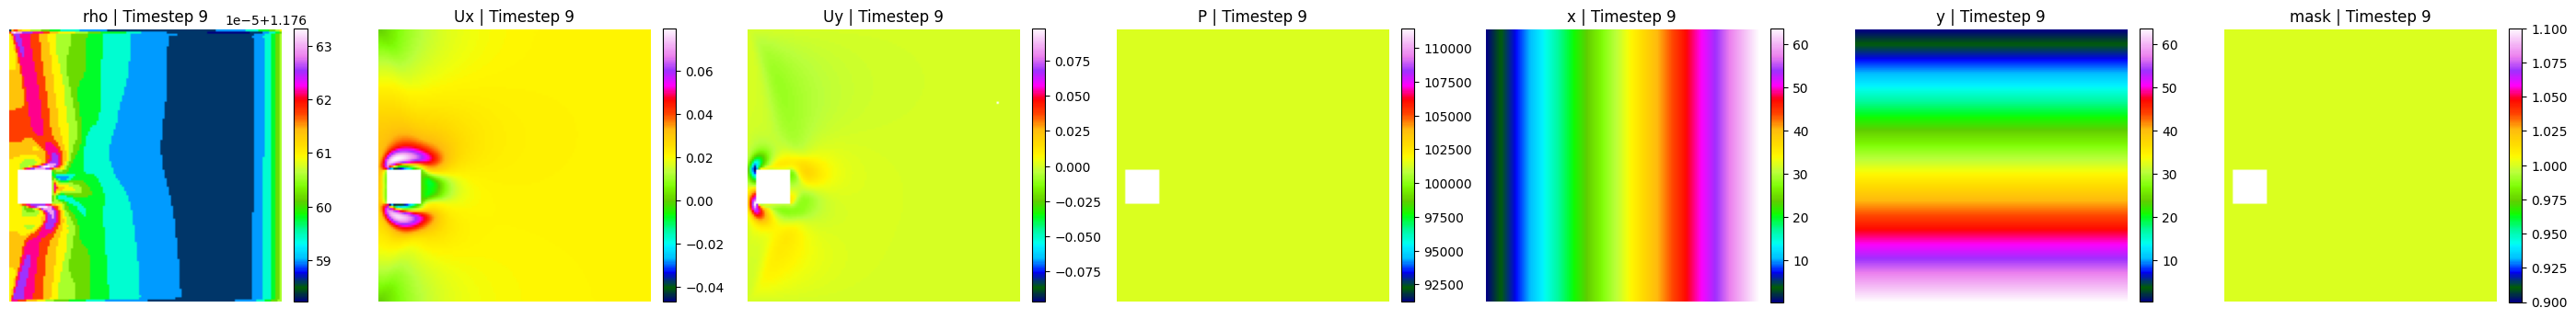

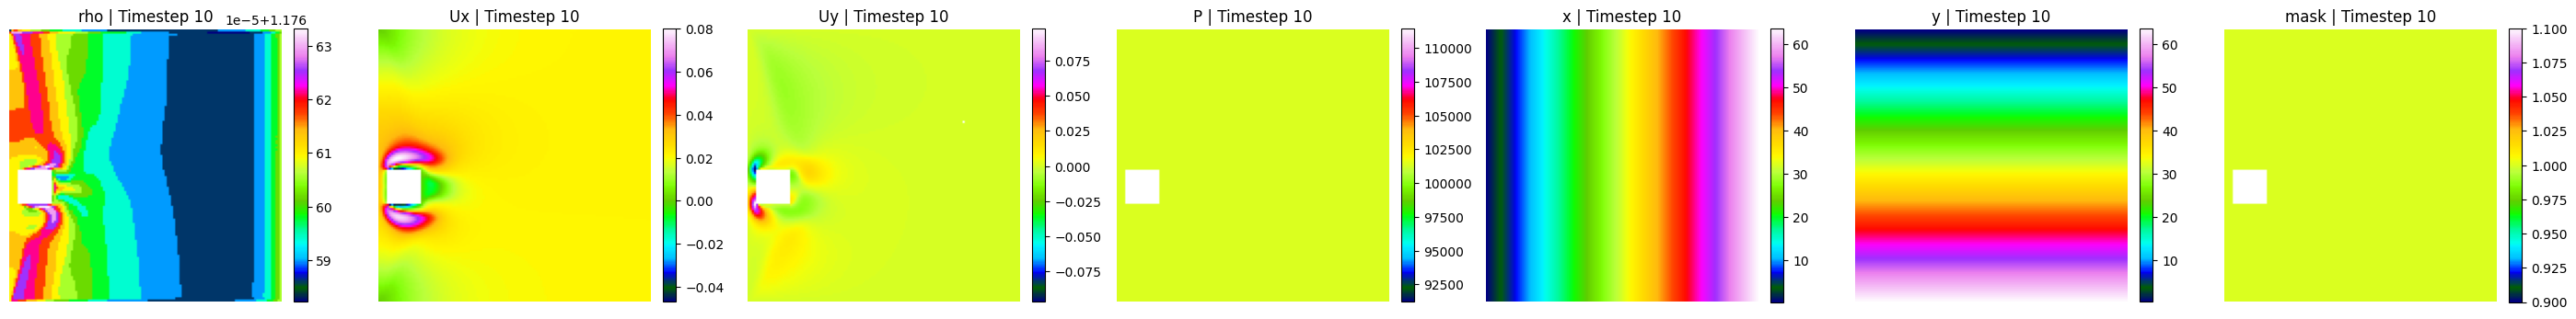

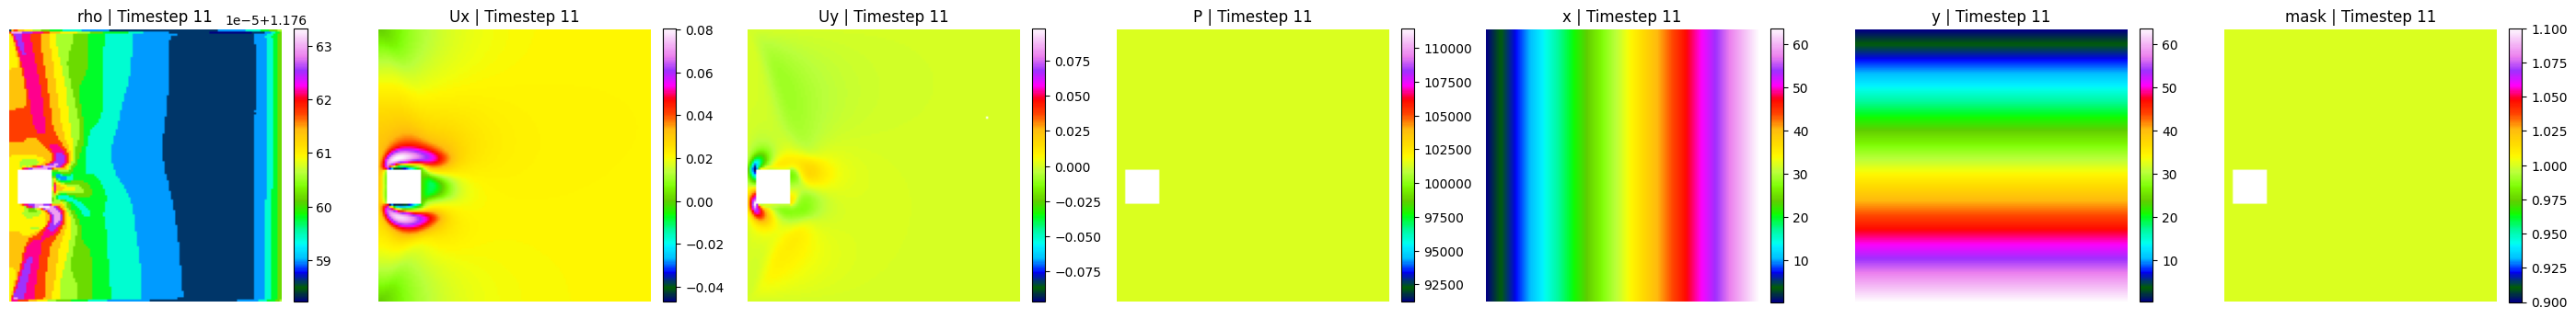

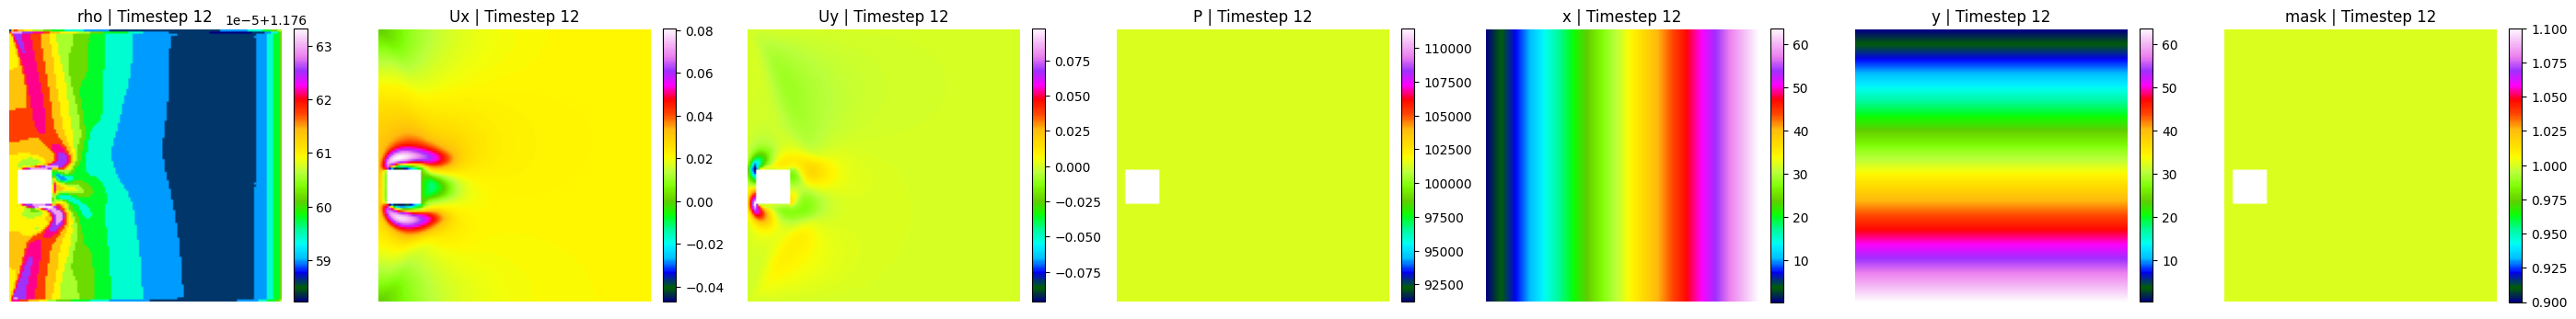

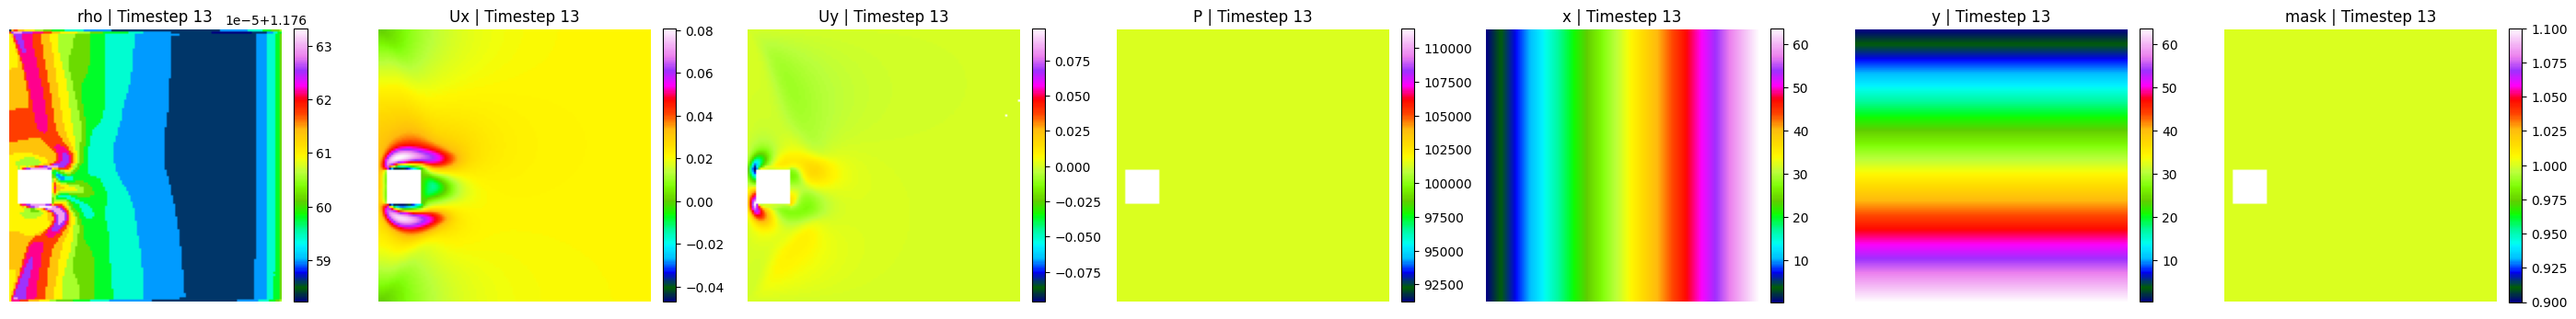

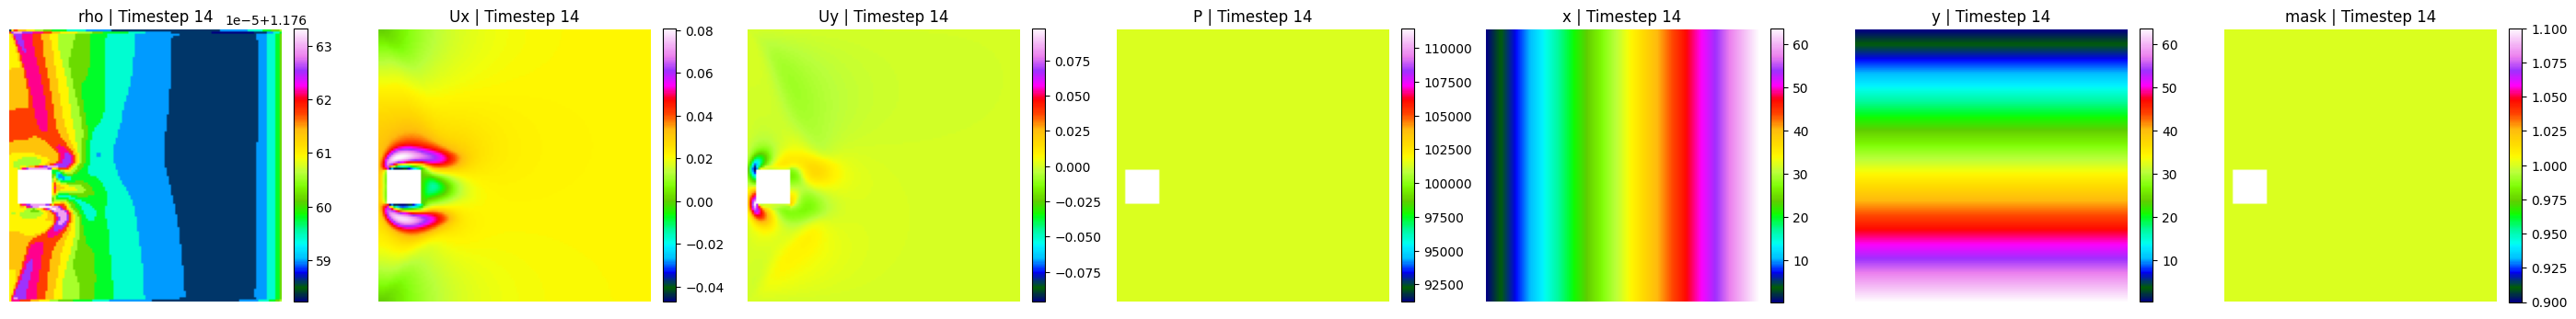

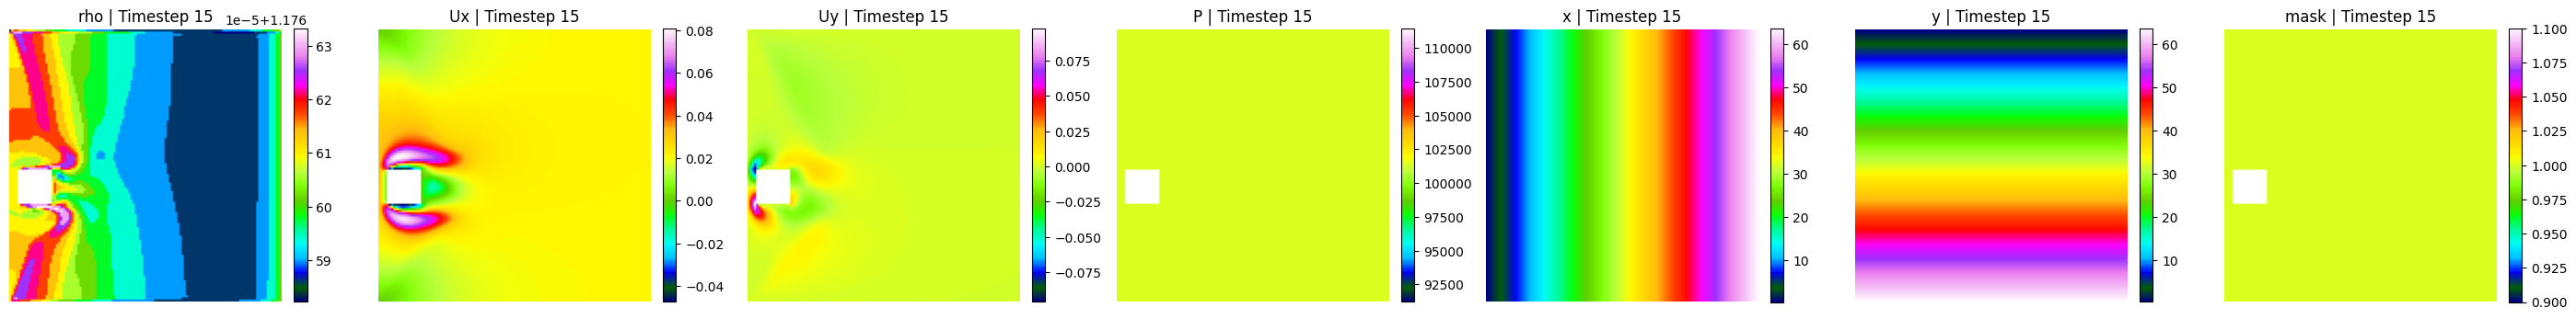

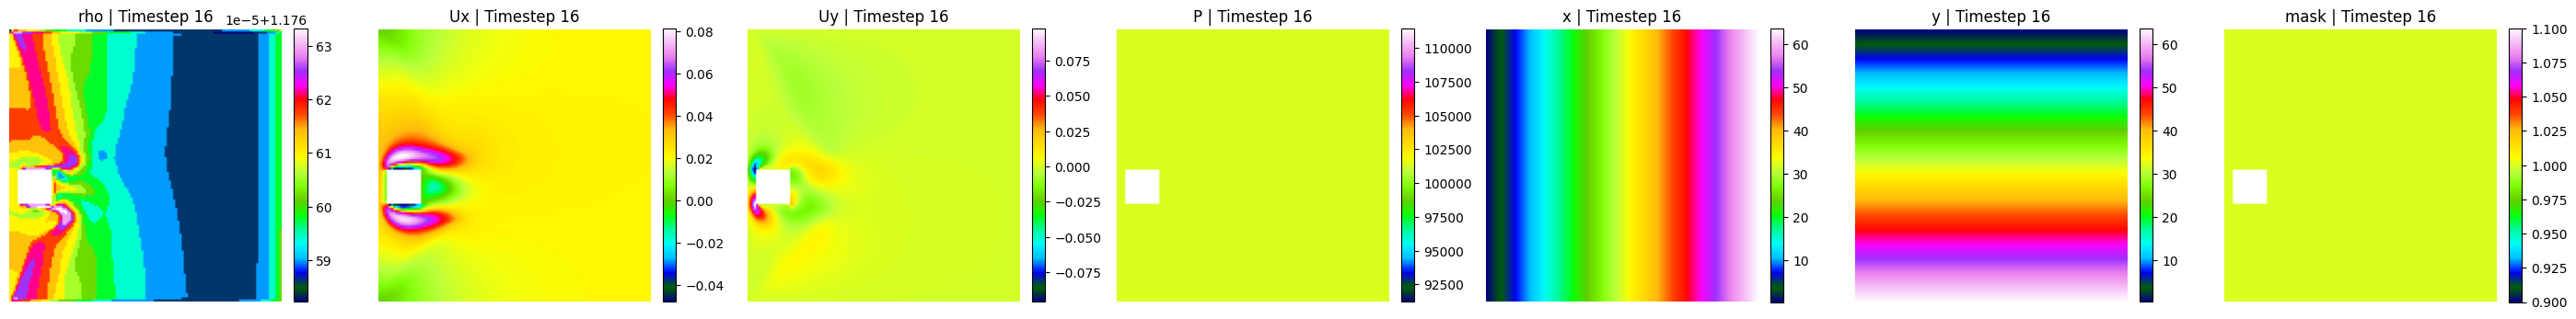

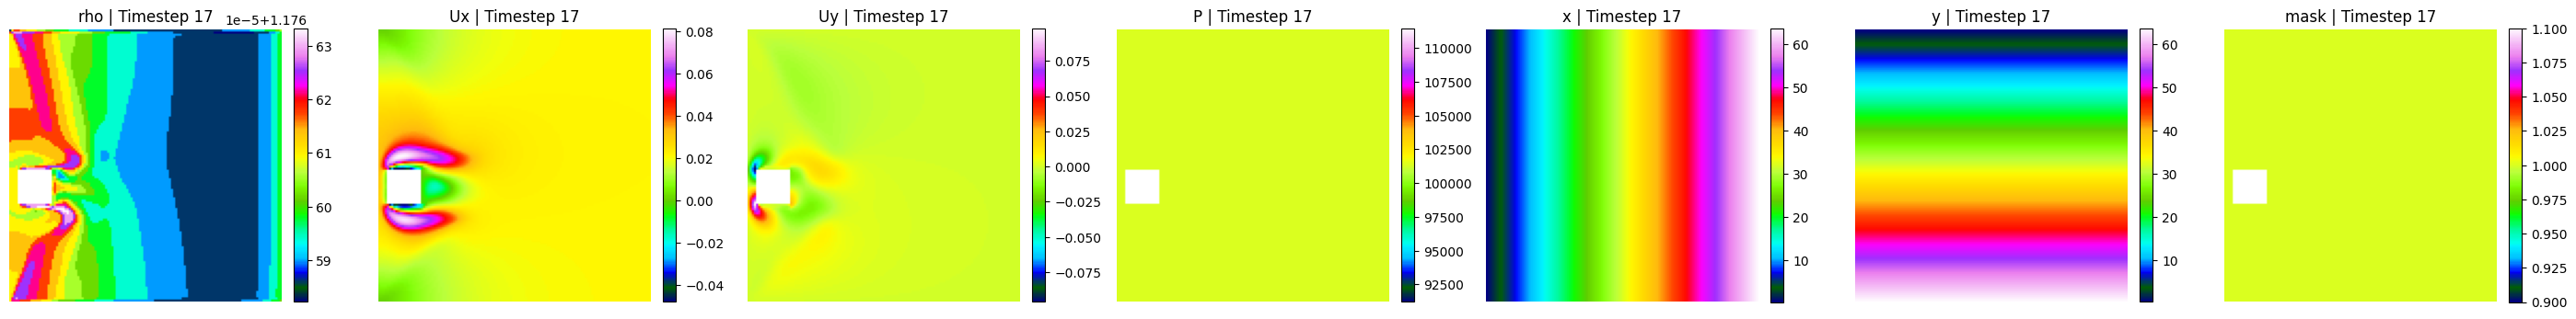

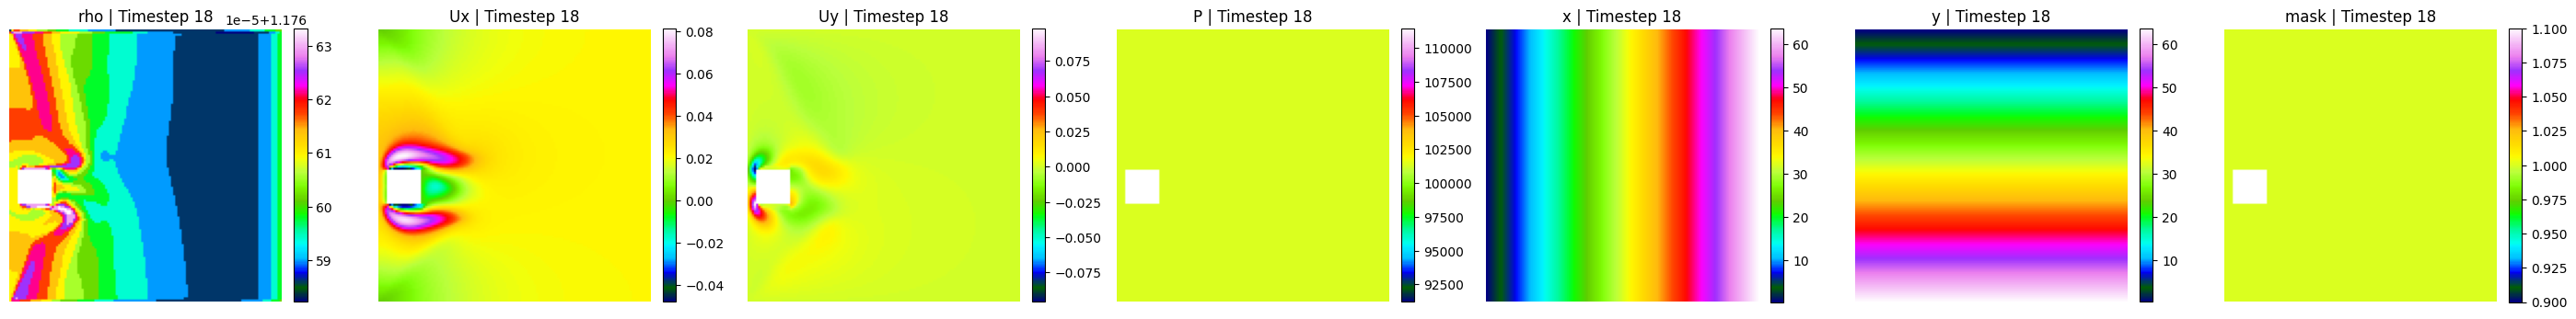

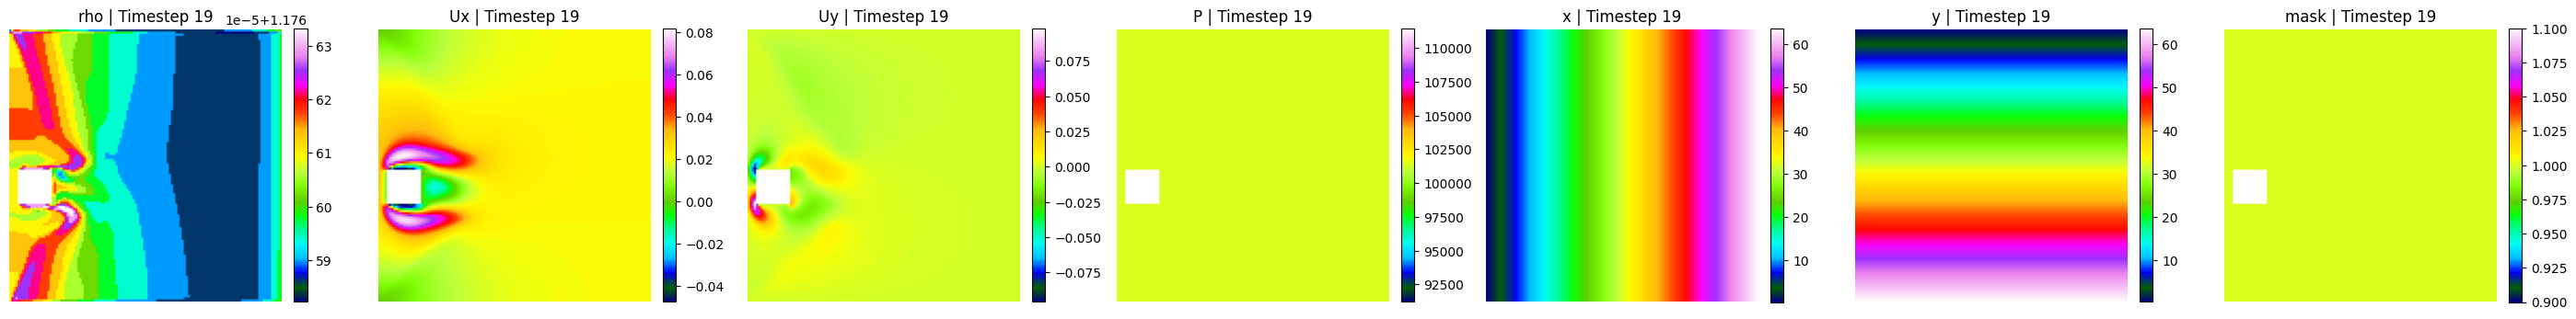

In [2]:
import os
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

# ========== HELPER FUNCTIONS (same as before) ==========

def parse_c_contents(c_contents):
    """
    Parses the OpenFOAM cell centers from a given 'c_contents' string.
    Expects the string to contain an 'internalField' entry.
    """
    lines = c_contents.split("\n")
    start_idx = None
    num_centres = None
    
    for i, line in enumerate(lines):
        if "internalField" in line:
            num_centres = int(lines[i+1].strip())
            start_idx = i + 3
            break

    if start_idx is None or num_centres is None:
        raise ValueError("Could not find 'internalField' or the number of cell centres in the content")

    coordinates = []
    for line in lines[start_idx:start_idx + num_centres]:
        if "(" in line and ")" in line:
            x, y, _ = map(float, line.strip("()\n").split())
            coordinates.append([x, y])

    return np.array(coordinates)


def reshape_trajectory_data(sim_data, cell_centers, grid_shape):
    """
    Reshape simulation data (timesteps, num_cells, 4) to a fixed grid of shape
      (timesteps, n_rows, n_cols, 7).

    Channels:
      0: rho
      1: Ux
      2: Uy
      3: P
      4: x-coordinate
      5: y-coordinate
      6: hole indicator (1 if fluid domain; 0 if hole)
    """
    n_rows, n_cols = grid_shape
    T = sim_data.shape[0]

    # Determine domain boundaries
    x_min, x_max = np.min(cell_centers[:, 0]), np.max(cell_centers[:, 0])
    y_min, y_max = np.min(cell_centers[:, 1]), np.max(cell_centers[:, 1])

    reshaped = np.zeros((T, n_rows, n_cols, 7), dtype=np.float32)

    # 1) Fill x,y coordinates for each (row, col)
    x_grid = np.linspace(x_min, x_max, n_cols)
    y_grid = np.linspace(y_min, y_max, n_rows)
    for row in range(n_rows):
        for col in range(n_cols):
            reshaped[:, row, col, 4] = x_grid[col]
            reshaped[:, row, col, 5] = y_grid[row]

    # 2) Create a hole mask
    #    Initialize with zeros (i.e., assume "hole"),
    #    then switch to 1 for valid fluid cells.
    mask = np.zeros((n_rows, n_cols), dtype=np.float32)  # 0 = hole
    mapping = []
    for (x, y) in cell_centers:
        col = int(round((x - x_min) / (x_max - x_min) * (n_cols - 1)))
        row = int(round((y - y_min) / (y_max - y_min) * (n_rows - 1)))
        mapping.append((row, col))
        mask[row, col] = 1  # 1 = fluid domain

    # 3) Fill the simulation data
    for t in range(T):
        for i, (row, col) in enumerate(mapping):
            reshaped[t, row, col, 0:4] = sim_data[t, i, :]

    # 4) Set the mask channel
    for t in range(T):
        reshaped[t, :, :, 6] = mask

    return reshaped


def combine_and_reshape_trajectories(dataset, sim_data_list, grid_shape, save_folder, file_name="combined.npy"):
    """
    dataset: shape (num_trajectories, timesteps, num_cells, 4)
    sim_data_list: list of dicts, each with "folder" and "c_contents"
    grid_shape: (n_rows, n_cols)

    Returns an array of shape (num_trajectories, timesteps, n_rows, n_cols, 7).
    """
    num_trajectories = dataset.shape[0]
    if num_trajectories != len(sim_data_list):
        raise ValueError(f"Number of simulations in .npy ({num_trajectories}) "
                         f"does not match the number of JSON entries ({len(sim_data_list)}).")

    combined_list = []
    
    for i in tqdm(range(num_trajectories), desc="Reshaping Trajectories"):
        sim_data = dataset[i]  # (timesteps, num_cells, 4)
        entry = sim_data_list[i]
        
        folder_name = entry["folder"]
        c_contents = entry["c_contents"]
        
        # Parse the cell centers
        cell_centers = parse_c_contents(c_contents)
        reshaped_data = reshape_trajectory_data(sim_data, cell_centers, grid_shape)
        combined_list.append(reshaped_data)
        gc.collect()
        
    combined = np.array(combined_list, dtype=np.float32)
    os.makedirs(save_folder, exist_ok=True)
    save_path = os.path.join(save_folder, file_name)
    np.save(save_path, combined)
    print(f"Saved combined trajectory data at: {save_path}")
    return combined


def plot_with_hole_white(
    trajectory, 
    channel_names=["rho", "Ux", "Uy", "P", "x", "y", "mask"], 
    tol=1e-8
):
    """
    Plot each timestep of a trajectory such that values whose absolute value
    is below a given tolerance are displayed as white (masked).
    """
    cmap = matplotlib.cm.get_cmap('gist_ncar').copy()
    cmap.set_bad(color='white')

    n_timesteps = trajectory.shape[0]
    for t in range(n_timesteps):
        data = trajectory[t]
        n_channels = data.shape[-1]
        
        fig, axes = plt.subplots(1, n_channels, figsize=(4*n_channels, 4))
        for ch in range(n_channels):
            masked_channel = np.ma.masked_where(np.abs(data[:, :, ch]) < tol, data[:, :, ch])
            valid_vals = data[:, :, ch][np.abs(data[:, :, ch]) >= tol]
            if valid_vals.size > 0:
                vmin, vmax = valid_vals.min(), valid_vals.max()
            else:
                vmin, vmax = 0, 1
            im = axes[ch].imshow(masked_channel, cmap=cmap, vmin=vmin, vmax=vmax)
            axes[ch].set_title(f"{channel_names[ch]} | Timestep {t}")
            axes[ch].axis("off")
            fig.colorbar(im, ax=axes[ch], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
        plt.close(fig)


def main():
    data_path = "/home/openfoamuser/Geo-UPSplus/dataset_gen/Flowbench_Openfoam/FPO_cylinder/Hole_Location/results_batch_1.npy"
    json_c_file_path = "/home/openfoamuser/Geo-UPSplus/dataset_gen/Flowbench_Openfoam/FPO_cylinder/Hole_Location/sim_data_batch_1.json"
    output_folder = "output"
    os.makedirs(output_folder, exist_ok=True)
    
    # 1. Load the simulation data
    print(f"Loading simulation data from {data_path}")
    data = np.load(data_path)  # (384, 20, 16128, 4)
    print(f"Data shape: {data.shape}")
    n_sims = data.shape[0]
    
    # 2. Load the JSON file, which apparently has 768 entries
    print(f"Loading JSON file: {json_c_file_path}")
    with open(json_c_file_path, "r") as f:
        raw_entries = json.load(f)  # 768 entries total

    print(f"Loaded JSON with {len(raw_entries)} entries total.")
    
    # 3. Slice from index 384 to the end => last 384 entries
    # sim_data_list = raw_entries[384:]
    # print(f"Using slice [384:] => {len(sim_data_list)} entries now.")

    # 4. Verify we have 384 entries to match the 384 simulations
    if len(raw_entries) != n_sims:
        raise ValueError(f"Mismatch: {len(raw_entries)} JSON entries vs {n_sims} simulations.")

    # 5. Reshape the trajectories
    grid_shape = (128, 128)
    combined_data = combine_and_reshape_trajectories(data, raw_entries, grid_shape, save_folder="FNO_data")
    print(f"Combined reshaped data shape: {combined_data.shape}")

    # 6. Plot a sample trajectory
    print("Plotting sample trajectory (index 58)...")
    plot_with_hole_white(combined_data[0])

if __name__ == "__main__":
    main()
